# Stroke Prediction
 - Data aquired from: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset
 - Code to be used for a blog post on handling imbalanced data.
 - Presented here: https://sinnott-cj.medium.com/stroke-prediction-imbalanced-data-b6c406a81b8a

#### Importing Libraries

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,\
                            precision_score, recall_score, roc_auc_score,\
                            plot_confusion_matrix, classification_report, plot_roc_curve, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#from category_encoders import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [100]:
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest

# Data Import & Cleaning

In [101]:
cd stroke_prediction

[Errno 2] No such file or directory: 'stroke_prediction'
/Users/coreysinnott/Desktop/personal_git/Works_in_progress/stroke_prediction


In [102]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

In [103]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [104]:
df.shape

(5110, 12)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Binarizing / Vectorizing where possible:

In [106]:
text_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
[print(df[i].unique()) for i in df[text_cols]]

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


[None, None, None, None, None]

In [107]:
df['gender'] = np.where(df['gender'] == 'Male', 1, 0)

In [108]:
df['ever_married'] = np.where(df['ever_married'] == 'Yes', 1, 0)

In [109]:
df['Residence_type'] = np.where(df['Residence_type'] == 'Urban', 1, 0)

In [110]:
df['smoking_status'] = np.where(((df['smoking_status'] == 'smokes') | (df['smoking_status'] == 'formerly smoked')), 1, 0)

In [111]:
for i in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    print(df[i].unique())

[1 0]
[1 0]
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
[1 0]
[1 0]


In [112]:
#not imputing bmi due to the clinical importance as seen in the heatmap
df.dropna(subset = ['bmi'], inplace = True)

Highly imbalanced classes:

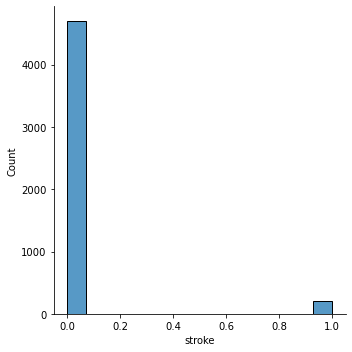

In [113]:
sns.displot(df.stroke);

In [114]:
df.stroke.value_counts()

0    4700
1     209
Name: stroke, dtype: int64

Removing outliers:

In [115]:
iso = IsolationForest(n_estimators = 1000, contamination = 0.03)

In [116]:
outs = pd.Series(iso.fit_predict(df[['bmi', 'avg_glucose_level']]), name = 'outliers')

In [117]:
outs.value_counts()

 1    4761
-1     148
Name: outliers, dtype: int64

In [118]:
df = pd.concat([outs.reset_index(), df.reset_index()], axis = 1, ignore_index = False).drop(columns = 'index')

In [119]:
df.head(3)

,outliers,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,9046,1,67.0,0,1,1,Private,1,228.69,36.6,1,1
1,1,31112,1,80.0,0,1,1,Private,0,105.92,32.5,0,1
2,1,60182,0,49.0,0,0,1,Private,1,171.23,34.4,1,1


In [120]:
df = df[df['outliers'] == 1]

In [121]:
df.shape

(4761, 13)

In [122]:
# lost 39 positive for stroke values
# may need to adjust to include more values
df['stroke'].value_counts()

0    4564
1     197
Name: stroke, dtype: int64

# Visualizations

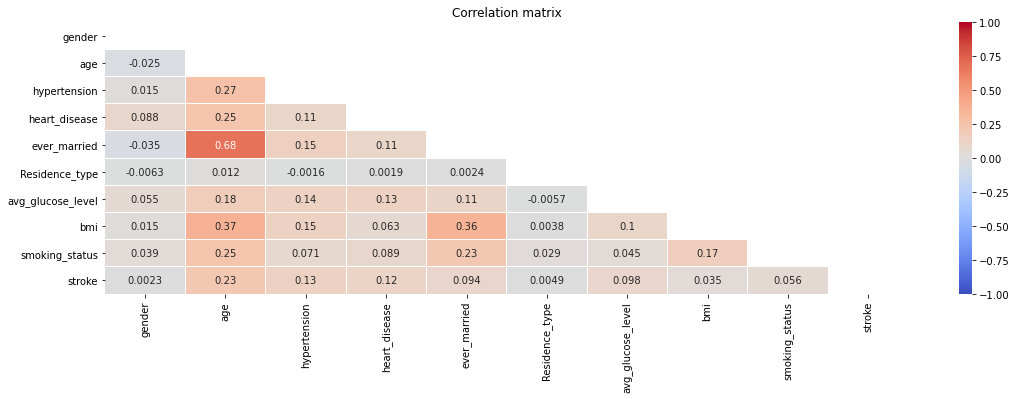

In [348]:
import matplotlib.pyplot as plt
mask = np.zeros_like(df.drop(columns = ['outliers', 'id']).corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18, 5))
sns.heatmap(
    df.drop(columns = ['outliers', 'id']).corr(),
    cmap='coolwarm',
    annot=True,
    mask=mask,
    vmin=-1.,
    vmax=1.,
    linewidths=.01
)
plt.title('Correlation matrix');
#everything has a colinear relationship with age

# Model Testing
- StandardScaler for numeric data.
- LabelEncoding for strings
- Different approaches to imbalanced target

No handling of imbalance:

In [354]:
X = df.drop(columns = ['stroke', 'id', 'outliers'])
y = df.stroke

In [355]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [356]:
print(f'Null model accuracy: {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

Null model accuracy: 0.96


In [359]:
mct = make_column_transformer(
        (StandardScaler(), make_column_selector(dtype_include = np.number)),
        (OneHotEncoder(), make_column_selector(dtype_include = object))
)

In [360]:
X_train = mct.fit_transform(X_train)

In [361]:
X_test = mct.transform(X_test)

In [362]:
rf = RandomForestClassifier()

In [363]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [364]:
y_pred = rf.predict(X_test)

In [365]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

classification_eval(y_test, y_pred)

accuracy  = 0.96
precision = 0.0
recall    = 0.0
f1-score  = 0.0
roc auc   = 0.5
null accuracy = 0.96


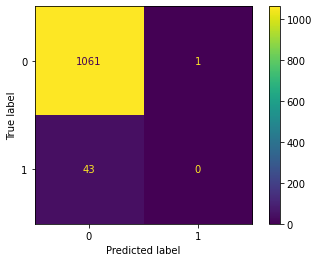

In [366]:
plot_confusion_matrix(rf, X_test, y_test);

Pre-processing:

In [158]:
le = LabelEncoder()
ss = StandardScaler()

In [159]:
df['work_type'] = le.fit_transform(df['work_type'])

In [160]:
num_cols = ['age', 'avg_glucose_level', 'bmi']

In [161]:
df[num_cols] = ss.fit_transform(df[num_cols])

In [208]:
X = df.drop(columns = ['stroke', 'id', 'outliers'])
y = df.stroke

RandomOversampler: *best performing technique*

In [172]:
from imblearn.over_sampling import RandomOverSampler

In [173]:
rs = RandomOverSampler()

In [174]:
X, y = rs.fit_resample(X, y)

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [176]:
rf = RandomForestClassifier()

In [177]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [178]:
y_pred = rf.predict(X_test)

In [179]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

classification_eval(y_test, y_pred)

accuracy  = 0.993
precision = 0.986
recall    = 1.0
f1-score  = 0.993
roc auc   = 0.993
null accuracy = 0.5


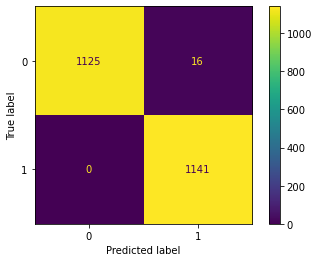

In [180]:
plot_confusion_matrix(rf, X_test, y_test);

SMOTE:

In [182]:
from imblearn.over_sampling import SMOTE

In [183]:
sm = SMOTE()

In [184]:
X, y = sm.fit_resample(X, y)

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [186]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [187]:
y_pred = rf.predict(X_test)

In [188]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

classification_eval(y_test, y_pred)

accuracy  = 0.938
precision = 0.917
recall    = 0.963
f1-score  = 0.939
roc auc   = 0.938
null accuracy = 0.5


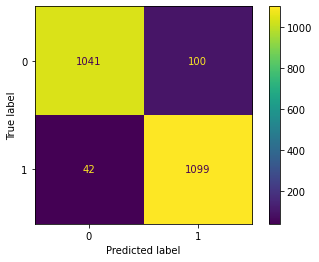

In [189]:
plot_confusion_matrix(rf, X_test, y_test);

ADASYN:

In [163]:
from imblearn.over_sampling import ADASYN

In [191]:
ad = ADASYN()

In [192]:
X, y = ad.fit_resample(X, y)

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [194]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [195]:
y_pred = rf.predict(X_test)

In [196]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

classification_eval(y_test, y_pred)

accuracy  = 0.933
precision = 0.909
recall    = 0.963
f1-score  = 0.935
roc auc   = 0.933
null accuracy = 0.5


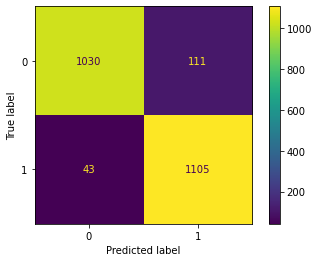

In [197]:
plot_confusion_matrix(rf, X_test, y_test);

SMOTENC

In [200]:
from imblearn.over_sampling import SMOTENC

In [201]:
sm = SMOTENC(categorical_features = [0, 2])

In [202]:
X, y = sm.fit_resample(X, y)

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [204]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [205]:
y_pred = rf.predict(X_test)

In [206]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

classification_eval(y_test, y_pred)

accuracy  = 0.94
precision = 0.917
recall    = 0.968
f1-score  = 0.942
roc auc   = 0.94
null accuracy = 0.5


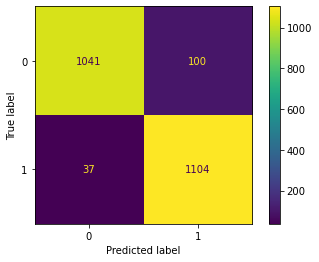

In [207]:
plot_confusion_matrix(rf, X_test, y_test);

In [209]:
hgb = HistGradientBoostingClassifier()

In [210]:
hgb.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [211]:
y_pred = hgb.predict(X_test)

In [212]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

classification_eval(y_test, y_pred)

accuracy  = 0.936
precision = 0.911
recall    = 0.966
f1-score  = 0.937
roc auc   = 0.936
null accuracy = 0.5


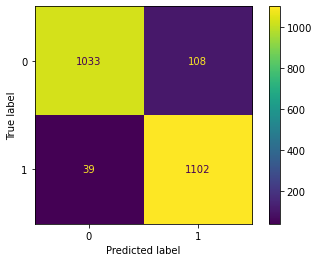

In [213]:
plot_confusion_matrix(hgb, X_test, y_test);

# Best Model:

In [214]:
def stroke_predictor (df):
    """
    """
    le = LabelEncoder()
    ss = StandardScaler()

    df['work_type'] = le.fit_transform(df['work_type'])

    num_cols = ['age', 'avg_glucose_level', 'bmi']
    df[num_cols] = ss.fit_transform(df[num_cols])
    
    X = df.drop(columns = ['stroke', 'id', 'outliers'])
    y = df.stroke
    
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
    
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')
    
    return model, X_train, X_test, y_train, y_test, y_pred

In [215]:
model, X_train, X_test, y_train, y_test, y_pred = stroke_predictor(df)

accuracy  = 0.991
precision = 0.983
recall    = 1.0
f1-score  = 0.991
roc auc   = 0.991
null accuracy = 0.5


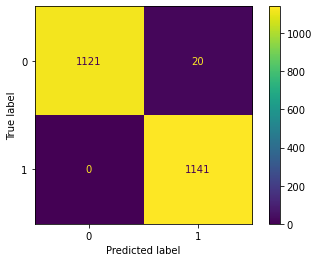

In [217]:
plot_confusion_matrix(model, X_test, y_test);

In [218]:
y_pred_prob = model.predict_proba(X_test)

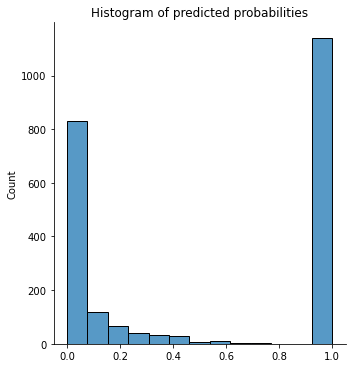

In [219]:
sns.displot(y_pred_prob[:, 1]);
plt.title('Histogram of predicted probabilities');

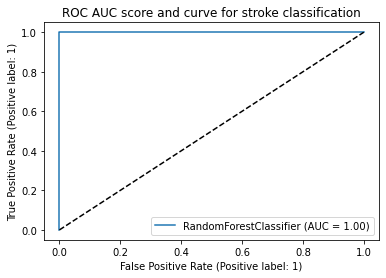

In [221]:
plot_roc_curve(model, X_test, y_test)
plt.title('ROC AUC score and curve for stroke classification');
plt.plot([0,1], [0,1], 'k--')
plt.show();

In [222]:
feat_names = [i for i in X_train]

In [223]:
classed = [i for i in y_train]

In [224]:
feat_import_df = pd.DataFrame({'importances': model.feature_importances_, 
 'name': feat_names}).sort_values('importances')

In [225]:
feat_import_df.sort_values('importances', ascending = False).head(15)

,importances,name
1,0.391667,age
7,0.215758,avg_glucose_level
8,0.178903,bmi
5,0.050370,work_type
4,0.040717,ever_married
2,0.034766,hypertension
9,0.025048,smoking_status
0,0.022739,gender
6,0.021038,Residence_type
3,0.018994,heart_disease


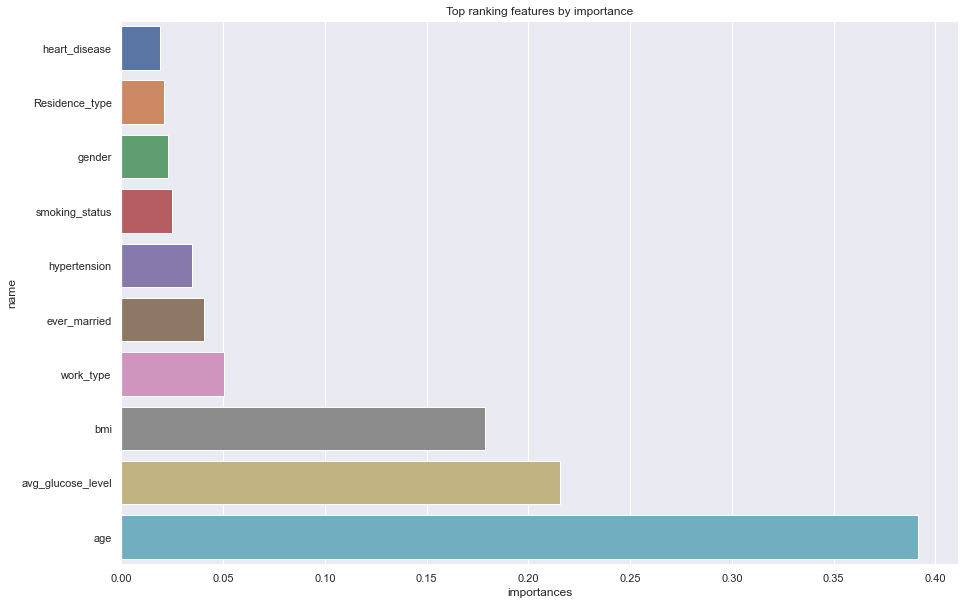

In [226]:
sns.set(style="darkgrid", context="notebook")
plt.figure(figsize=(15, 10))
x = feat_import_df['importances'].tail(21)
y = feat_import_df['name'].tail(21)
sns.barplot(x = x, y = y).set_title('Top ranking features by importance');